# **Data Visualization Notebook**

## Objectives

* Answer business requirement 1: 
* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

* Train Dataset
* Validation Dataset
* Test Dataset

## Outputs

* Average images and variability images for each class (healthy or powdery mildew).
* The differences between average healthy and average powdery mildew cherry leaves.
* An image montage for each class.

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between mildew infected leaves and non-infected images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.


## Additional Comments

* No additional comments.



---

# Set Data Directory

---

## Import libraries

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import pandas as pd

sns.set_style("white")

## Set working directory

In [5]:
cwd= os.getcwd()
os.chdir('/workspace/mildew-detection')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/mildew-detection'

## Import dataframes

In [6]:
import pandas as pd

# Paths to the CSV files previously created
train_csv_path = 'train_dataframe.csv'
validation_csv_path = 'validation_dataframe.csv'
test_csv_path = 'test_dataframe.csv'

# Read the CSV files into dataframes
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(validation_csv_path)
test_df = pd.read_csv(test_csv_path)

---

## Set input directories

Set train, validation and test paths using the dataframes

In [7]:
# Define input directories from dataframes
train_path = train_df['file']
validation_path = validation_df['file']
test_path = test_df['file']

## Set output directory

In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(os.path.join(work_dir, 'outputs')):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set label names

In [9]:
# Extract labels from the train DataFrame
labels = train_df['file'].apply(os.path.basename)
print('Labels for the images are:', labels.unique())

Labels for the images are: ['0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092.JPG'
 '0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092_180deg.JPG'
 '0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092_flipTB.JPG' ...
 'ffdeb404-b84d-4389-9cc9-e1d3159374fe___FREC_Pwd.M 4625.JPG'
 'ffdeb404-b84d-4389-9cc9-e1d3159374fe___FREC_Pwd.M 4625_flipLR.JPG'
 'fff3ae4b-4bce-4b7a-b53c-98c482d9d8fd___FREC_Pwd.M 0414.JPG']


---

# Data visualisation of image data

---

## Image shape 

Compute average images size on train set using OpenCV. https://note.nkmk.me/en/python-opencv-pillow-image-size/

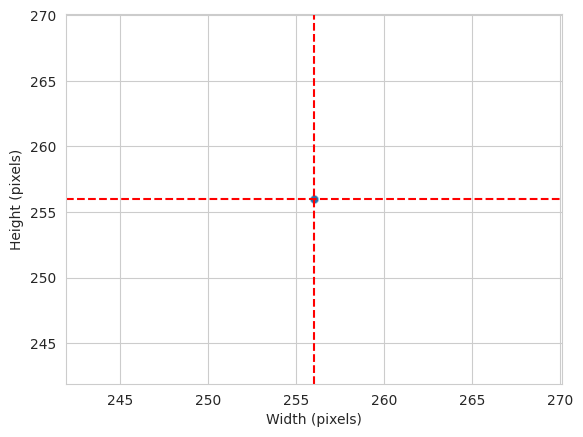

Width average: 256 
Height average: 256


['outputs/v1/image_shape.pkl']

In [10]:
# Initialize lists to store dimensions
dim1, dim2 = [], []

# Iterate through images in the train dataframe
for index, row in train_df.iterrows():
    img = cv2.imread(row['file'])
    if img is not None:
        h, w, _ = img.shape
        dim1.append(h)  # image height
        dim2.append(w)  # image width

# Visualize the distribution of image sizes
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()

# Print and save the average image shape
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")
image_shape = (dim1_mean, dim2_mean, 3)
# Save the image shape embeddings
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

---

## Average and variability of images per label

Function to load images in an array with OpenCV and then resize the images. https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image

In [11]:
def load_image_as_array(dataframe, new_size=(50, 50, 3), n_images_per_label=20):
    X, y = [], []
    
    # Iterate through each row in the dataframe
    for index, row in dataframe.iterrows():
        img_path = row['file']
        label = row['label']
        
        # Load and preprocess the image
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, dsize=new_size[:2], interpolation=cv2.INTER_CUBIC)  # Resize to specified size
        img_array = img_resized.astype(np.float32) / 255.0  # Normalize pixel values

        # Append image and label to X and y lists
        X.append(img_array)
        y.append(label)
    
    return np.array(X), np.array(y)

# Set the base directory and image directories
data_dir = "/workspace/mildew-detection/inputs/datasets" 
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Define image shape
image_shape = (50, 50, 3)

# Load images from dataframes
X_train, y_train = load_image_as_array(dataframe=train_df, new_size=image_shape, n_images_per_label=30)
X_validation, y_validation = load_image_as_array(dataframe=validation_df, new_size=image_shape, n_images_per_label=30)
X_test, y_test = load_image_as_array(dataframe=test_df, new_size=image_shape, n_images_per_label=30)

# Print shapes of the loaded data
print("Train images shape:", X_train.shape)
print("Validation images shape:", X_validation.shape)
print("Test images shape:", X_test.shape)
print("Train labels shape:", y_train.shape)
print("Validation labels shape:", y_validation.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (2944, 50, 50, 3)
Validation images shape: (420, 50, 50, 3)
Test images shape: (844, 50, 50, 3)
Train labels shape: (2944,)
Validation labels shape: (420,)
Test labels shape: (844,)


---

## Plot and save mean and variability of images per label 

Using the train dataframe for this function

==== Label healthy ====
Image Shape: (50, 50, 3)
==== Label powdery_mildew ====
Image Shape: (50, 50, 3)


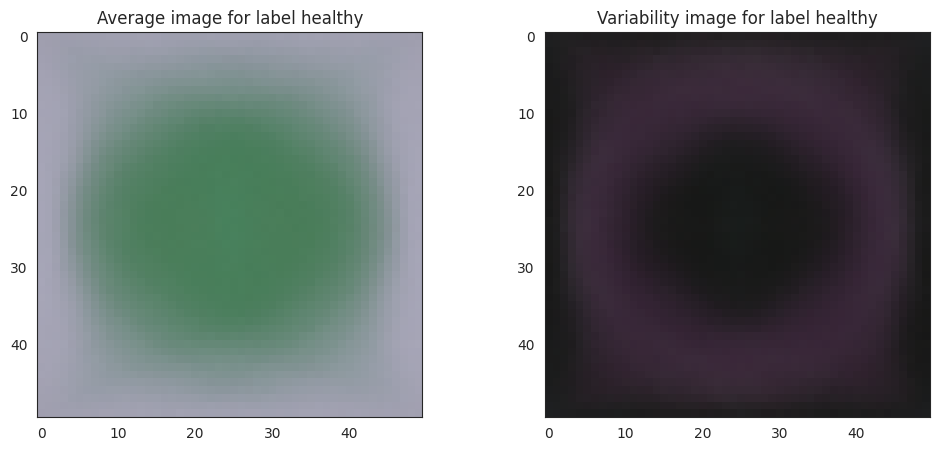

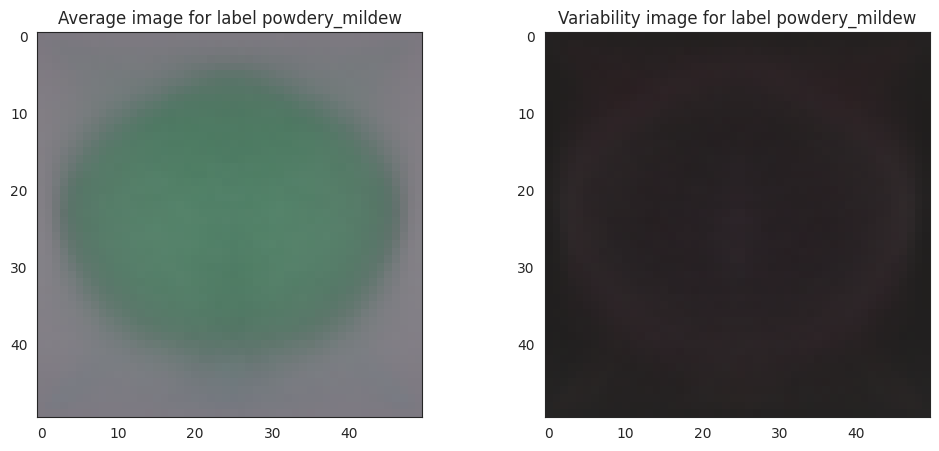

In [12]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, file_path="."):
    """
    Plot mean and variability of images per label.
    
    Parameters:
        X (numpy.ndarray): Array of images.
        y (numpy.ndarray): Array of corresponding labels.
        figsize (tuple): Size of the figure.
        save_image (bool): Whether to save the image or not.
        file_path (str): Path to save the images.
    """
    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

plot_mean_variability_per_labels(X_train, y_train, figsize=(12, 5), save_image=True)

## Difference between average healthy and powdery mildew images

In [ ]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

In [ ]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='Parasitized', label_2='Healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

In [ ]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---